# Forestry ARR Eligibility - STAC Approach

This notebook demonstrates the STAC-based approach for forestry ARR eligibility analysis when historical Sentinel data is not available from Google Earth Engine.

## 📦 Required Libraries Installation

Before running this notebook, install the required libraries:

```bash
# Core STAC and GEE-xarray integration (REQUIRED)
pip install xarray>=2023.1.0 rioxarray>=0.15.0 xee>=0.0.8

# STAC client libraries
pip install planetary-computer>=0.4.0 pystac-client>=0.7.0 stackstac>=0.4.0

# Optional but recommended for better performance
pip install dask>=2023.1.0
```

Or install all at once:
```bash
pip install xarray rioxarray xee planetary-computer pystac-client stackstac dask
```

**Note:** `xarray` and `xee` are **required dependencies** - they enable Google Earth Engine integration with xarray for time series processing.

In [1]:
# Install required libraries for STAC processing
# Uncomment the line below if libraries are not installed
# !pip install xarray rioxarray xee planetary-computer pystac-client stackstac dask

# Verify installation - xarray and xee are REQUIRED
required_libs = {
    'xarray': 'xarray',  # REQUIRED - core dependency
    'rioxarray': 'rioxarray',  # REQUIRED - for geospatial raster operations
    'xee': 'xee',  # REQUIRED - Google Earth Engine to xarray bridge
    'planetary_computer': 'planetary-computer',  # For STAC access
    'pystac_client': 'pystac-client',  # For STAC client
    'stackstac': 'stackstac',  # For stacking STAC items
    'geopandas': 'geopandas',  # Core geospatial library
    'geemap': 'geemap'  # Optional - for GEE visualization
}

critical_libs = ['xarray', 'rioxarray', 'xee']  # Must-have libraries
missing_libs = []
missing_critical = []

for module_name, package_name in required_libs.items():
    try:
        __import__(module_name)
        status = "⭐" if module_name in critical_libs else "✅"
        print(f"{status} {module_name} is installed")
    except ImportError:
        status = "🚨" if module_name in critical_libs else "❌"
        print(f"{status} {module_name} is MISSING - install with: pip install {package_name}")
        missing_libs.append(package_name)
        if module_name in critical_libs:
            missing_critical.append(package_name)

if missing_critical:
    print(f"\n🚨 CRITICAL: Missing required libraries! Install them with:")
    print(f"   pip install {' '.join(missing_critical)}")
    raise ImportError(f"Required libraries missing: {', '.join(missing_critical)}")
elif missing_libs:
    print(f"\n⚠️ Missing optional libraries. Install them with:")
    print(f"   pip install {' '.join(missing_libs)}")
else:
    print("\n✅ All required libraries are installed!")


⭐ xarray is installed
⭐ rioxarray is installed
⭐ xee is installed
✅ planetary_computer is installed
✅ pystac_client is installed
✅ stackstac is installed
✅ geopandas is installed
✅ geemap is installed

✅ All required libraries are installed!


In [2]:
# !pip install xarray rioxarray xee planetary-computer pystac-client stackstac dask

In [3]:
from forestry_carbon_arr.core import ForestryCarbonARR

# Initialize Forestry Carbon ARR system
forestry = ForestryCarbonARR(config_path='./00_input/balaban_conf.json')
from_gee_version_1_config = forestry.config

In [4]:
from_gee_version_1_config

{'project': {'name': 'forestry_carbon_project',
  'region': 'global',
  'description': 'Forestry Carbon ARR Analysis Project',
  'version': '1.0.0'},
 'gee': {'project_id': None,
  'service_account': None,
  'initialize': True,
  'max_pixels': 10000000000000.0,
  'scale': 30,
  'crs': 'EPSG:4326'},
 'satellite': {'provider': 'Sentinel',
  'date_range': ['2024-01-01', '2024-12-31'],
  'cloud_cover_threshold': 40,
  'bands': {'Sentinel': ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'],
   'Planet': ['red', 'green', 'blue', 'nir'],
   'Landsat': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']},
  'composite_method': 'median',
  'mask_clouds': True},
 'ml': {'algorithm': 'gbm',
  'training_samples': 1000,
  'validation_split': 0.2,
  'cross_validation': True,
  'n_folds': 5,
  'random_state': 42,
  'hyperparameter_tuning': True},
 'fcd': {'method': 'pca',
  'thresholds': {'high_forest': 65,
   'yrf_forest': 55,
   'shrub_grass': 35,
   'open_land': 30},
  'apply_smoothing': True,
  'smoothing_kernel': 3},
 'c

In [5]:
### START TO WORK WITH STAC
import json
import geopandas as gpd
config = from_gee_version_1_config

#INPUT VARIABLES
is_export_image_to_drive = False

aoi_gpd = gpd.GeoDataFrame.from_file(config["AOI_path"])
aoi_gpd = aoi_gpd.to_crs(epsg=int(config['gee']["crs"].split(":")[-1])) # satellite crs is epsg code of projected UTM crs
if aoi_gpd.crs.to_string() == 'EPSG:4326':
    aoi_gpd = aoi_gpd.to_crs(epsg=3857)

aoi_ha = aoi_gpd.geometry.area.sum()/10000
print('area: (Ha) ', aoi_ha)

area: (Ha)  3411.880827453312


In [6]:
from forestry_carbon_arr.core.utils import DataUtils

d = DataUtils(config)
aoi_gpd, aoi_ee = d.load_geodataframe_gee(config["AOI_path"])

# we shall use the STAC approach if historical data of sentinel is not available from GEE 
# first we need to check in the AOI, date range availability, and do the historical data similar to the Hansen approach

# We should change the use_gee = True as use_hansen_gee = True vs use_tsfresh = True
# use_hansen_gee = True, is the first version of eligibility check that use landcover, and hansen tree cover
# use_tsfresh = True, is the second version of eligibility check that use tsfresh to extract the features from the time series of satellite data (replacing hansen) and current model will at the moment use 
## trees vs non-trees classification in use_tsfresh

# check the date range availability of the sentinel data - GEE xee, let's leverage the GEE with xarray,
from gee_lib.osi.image_collection.main import ImageCollection

# Create configuration for GEE ImageCollection

year_end = int(config['date_start_end'][1].split('-')[0])
ten_years_prior = year_end -10

new_date_start_end = [f'{ten_years_prior}-01-01', f"{config['date_start_end'][1]}"]

gee_config = {
    'AOI': aoi_ee,
    'date_start_end': new_date_start_end,
    'cloud_cover_threshold': config['cloud_cover_threshold'],
    'config': {'IsThermal': False}
}

# Initialize ImageCollection
image_collection = ImageCollection(
    I_satellite=config['I_satellite'],
    region=aoi_gpd,
    **gee_config
)

# Get the raw ImageCollection (not mosaicked)
raw_collection = image_collection.image_collection_mask()
## masking cloud, get xarray with applied cloud mask

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully
selecting Sentinel images


## Step 4.5: Convert to UTM CRS (meters)

**Why UTM?**
- UTM uses meters as units (not degrees like EPSG:4326)
- Scale parameter in xee should match CRS units
- Sentinel-2: 10m pixels means 10 meters, which only makes sense in UTM
- Better for spatial analysis and area calculations

**Steps:**
1. Determine UTM zone from AOI centroid longitude
2. Reproject raw_collection in Earth Engine to UTM
3. Update xee parameters to use UTM CRS and meter scale


In [7]:
# Step 1: Determine UTM zone from AOI centroid
# UTM zones are calculated based on longitude: zone = floor((lon + 180) / 6) + 1

import numpy as np

# Get centroid longitude (must be in WGS84/ EPSG:4326 for UTM calculation)
if aoi_gpd.crs.to_string() != 'EPSG:4326':
    aoi_wgs84 = aoi_gpd.to_crs('EPSG:4326')
else:
    aoi_wgs84 = aoi_gpd

centroid_lon = aoi_wgs84.geometry.centroid.x.mean()
centroid_lat = aoi_wgs84.geometry.centroid.y.mean()

# Calculate UTM zone
utm_zone = int(np.floor((centroid_lon + 180) / 6)) + 1

# Determine hemisphere (N or S) based on latitude
hemisphere = 'N' if centroid_lat >= 0 else 'S'

# UTM EPSG code format: EPSG:326XX (northern) or EPSG:327XX (southern)
if hemisphere == 'N':
    utm_epsg = 32600 + utm_zone  # Northern hemisphere
else:
    utm_epsg = 32700 + utm_zone  # Southern hemisphere

print(f"📍 AOI Centroid: ({centroid_lat:.4f}°, {centroid_lon:.4f}°)")
print(f"🗺️  UTM Zone: {utm_zone}{hemisphere}")
print(f"🔢 UTM EPSG Code: EPSG:{utm_epsg}")
print(f"📐 CRS Units: Meters (✅ matches scale units)")

# Update config with UTM CRS
config['utm_crs'] = f'EPSG:{utm_epsg}'
config['utm_zone'] = utm_zone
config['utm_hemisphere'] = hemisphere


📍 AOI Centroid: (-1.8038°, 110.4631°)
🗺️  UTM Zone: 49S
🔢 UTM EPSG Code: EPSG:32749
📐 CRS Units: Meters (✅ matches scale units)


/tmp/ipykernel_21/3455030237.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lon = aoi_wgs84.geometry.centroid.x.mean()
/tmp/ipykernel_21/3455030237.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_lat = aoi_wgs84.geometry.centroid.y.mean()


In [8]:
# Step 2: Reproject raw_collection to UTM in Earth Engine
# This ensures the ImageCollection is in meters before xee conversion

print("🔄 Reprojecting raw_collection to UTM...")

# Reproject each image in the collection to UTM
# scale: pixel size in meters (10m for Sentinel-2)
# crs: UTM EPSG code

if config['I_satellite'] == 'Sentinel':
    pixel_scale = 10  # meters for Sentinel-2
elif config['I_satellite'] == 'Landsat':
    pixel_scale = 30  # meters for Landsat
else:
    pixel_scale = 10  # default

# Reproject the collection
raw_collection_utm = raw_collection.map(
    lambda image: image.reproject(
        crs=f'EPSG:{utm_epsg}',
        scale=pixel_scale
    )
)

print(f"✅ Reprojected to {config['utm_crs']}")
print(f"   Scale: {pixel_scale}m (matches CRS units)")

# Update the collection variable
raw_collection = raw_collection_utm


🔄 Reprojecting raw_collection to UTM...
✅ Reprojected to EPSG:32749
   Scale: 10m (matches CRS units)


## Convert Earth Engine ImageCollection to xarray Dataset using xee

**What is xee?**
- `xee` (xarray-earth-engine) is a bridge library that connects Google Earth Engine with xarray
- It allows you to work with GEE ImageCollections as if they were xarray Datasets
- This enables time-series analysis, easy indexing, and integration with other xarray-based tools

**Why use xee?**
- Familiar xarray interface for Earth Engine data
- Lazy loading: only loads data when needed
- Time dimension: automatically handles time-series
- Easy integration with dask for parallel processing
- Works seamlessly with STAC workflows

**Key Concepts:**
- `xee.open_dataset()`: Main function to convert EE ImageCollection → xarray Dataset
- Requires: region (bounding box), scale (pixel size), and CRS
- Returns: xarray Dataset with dimensions (time, y, x) and data variables (bands)


In [9]:
# Step 1: Import xee library
import xee
import ee
import numpy as np
import geemap

# Step 2: Check the raw_collection structure
print("📊 Raw Collection Info:")
print(f"Type: {type(raw_collection)}")
print(f"Is ImageCollection: {isinstance(raw_collection, ee.ImageCollection)}")

# Step 3: Get the AOI bounding box in UTM (required for xee)
# First, transform aoi_ee geometry to UTM so bounds are in meters
print(f"\n🔄 Converting AOI geometry to UTM ({config['utm_crs']})...")
aoi_gpd_utm = aoi_gpd.to_crs(f'EPSG:{utm_epsg}')
aoi_gpd_utm.set_crs(f'EPSG:{utm_epsg}', inplace=True)

# aoi_ee_utm_geom = geemap.geopandas_to_ee(aoi_gpd_utm) # not possible, uploaded fc will automatically 4326

# # Get bounds from UTM geometry (now in meters)
# aoi_bounds_utm = aoi_ee_utm_geom.bounds().getInfo()
# print(f"📍 AOI Bounds (UTM): {aoi_bounds_utm}")

# # Extract the coordinates from UTM bounds
# coordinates_utm = aoi_bounds_utm['coordinates'][0]
# # xee expects region as a list: [west, south, east, north] or a GeoJSON-like dict
# # Bounds are now in meters (UTM)
# from shapely.geometry import box
# bounds_list_utm = [coordinates_utm[0][0], coordinates_utm[0][1], coordinates_utm[2][0], coordinates_utm[2][1]]
# print(f"Bounds list format [west, south, east, north] in meters: {bounds_list_utm}")
# print(f"   Note: These coordinates are in UTM meters, not degrees!")

# Also keep the UTM geometry for later use
# aoi_ee_utm = aoi_ee_utm_geom  # Save for use in xee conversion


📊 Raw Collection Info:
Type: <class 'ee.imagecollection.ImageCollection'>
Is ImageCollection: True

🔄 Converting AOI geometry to UTM (EPSG:32749)...


,FID_1,kode_prov,kode_kab,hd_id,nama_kec,nama_desa,nama_ld,no_sk_pphd,tgl_sk_pph,no_sk_pak_,...,st_length_,A1NAME,A1CODE,A2CODE,A2NAME,TYPE,A2TEXT,Hectares,id,geometry
0,554.0,61.0,6104.0,610418.0,Sungai Melayu Rayak,Sungai Melayu,LPHD Belaban Rayak,SK.4670/MENLHK-PSKL/PKPS/PSL.0/7/2018,2018/07/06 08:00:00.000,-,...,0.229771,KALIMANTAN BARAT,61.0,6106.0,KETAPANG,Kabupaten,6106,3385.72723,0,"POLYGON ((443293.000 9803079.000, 443402.418 9..."


In [10]:
# aoi_gpd_utm

In [11]:
# aoi_gpd_utm.geometry

In [12]:
# Step 4: Configure xee parameters for UTM
# Now we use UTM CRS (meters) which matches the scale units

# Scale is already set from previous step (10m for Sentinel-2)
print(f"📐 Pixel Scale: {pixel_scale}m ({config['I_satellite']})")

# Use UTM CRS (already calculated)
utm_crs = config['utm_crs']
print(f"🌍 CRS: {utm_crs} (UTM Zone {config['utm_zone']}{config['utm_hemisphere']})")
print(f"✅ Scale and CRS units both in meters - correct!")

# Extract EPSG code for xee
epsg_code = utm_epsg


📐 Pixel Scale: 10m (Sentinel)
🌍 CRS: EPSG:32749 (UTM Zone 49S)
✅ Scale and CRS units both in meters - correct!


<Axes: >

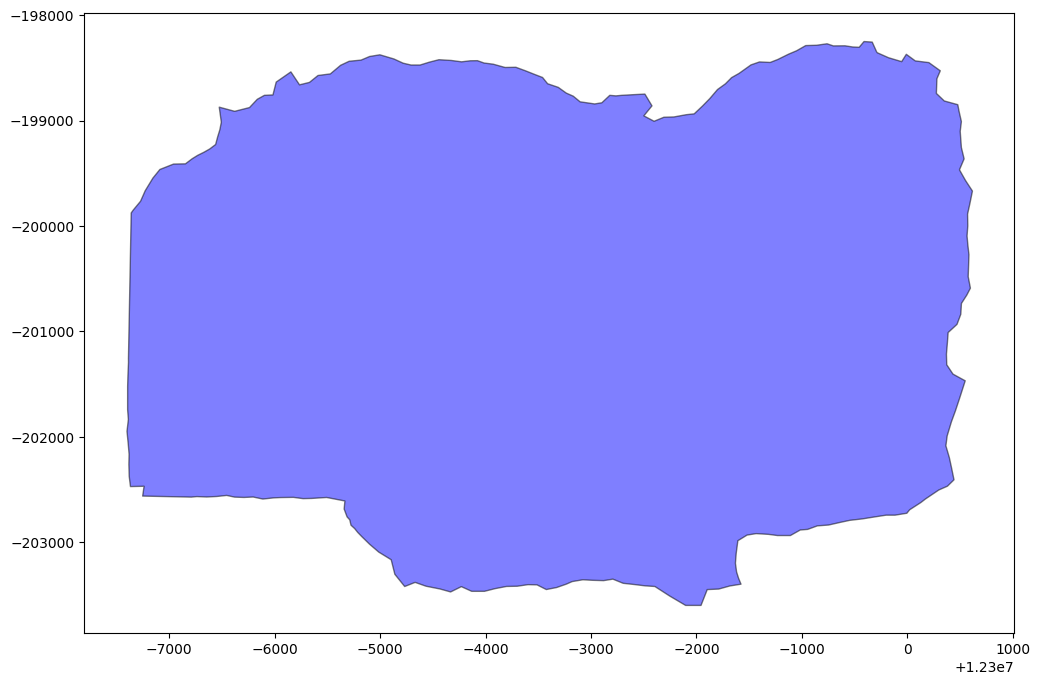

In [13]:
type(aoi_gpd)
# Simple way to plot geometry - just call .plot() method
aoi_gpd.plot(figsize=(12, 12), color='blue', edgecolor='black', alpha=0.5)

# Or use the geometry directly
# geom = aoi_gpd.geometry
# geom.plot(figsize=(10, 10), color='green', edgecolor='red', linewidth=2)


In [14]:
# display(geom)

In [15]:
pixel_scale

10

In [16]:
# raw_collection

In [17]:
# Add Spectral Indices to ImageCollection
# Map spectral indices over each image in the collection using SpectralAnalysis

from gee_lib.osi.spectral_indices.spectral_analysis import SpectralAnalysis

print("🔄 Adding spectral indices to ImageCollection...")
print(f"   Satellite: {config['I_satellite']}")
print("   Mapping indices over each image in collection...")

# Prepare config for SpectralAnalysis
spectral_config = {
    'I_satellite': config['I_satellite'],
    'AOI': aoi_ee.geometry(),  # Use the AOI geometry
    'pca_scaling': config.get('pca_scaling', 1),
    'tileScale': config.get('tileScale', 2)
}

# Define function to add spectral indices to a single image
def add_spectral_indices(image):
    """
    Add spectral indices to a single image using SpectralAnalysis.
    
    Available indices based on satellite type:
    - All: NDVI, NDWI, MSAVI2, MTVI2, VARI
    - Sentinel/Landsat: BSI (requires swir1)
    Note: AVI and SI require max_bands per image (expensive), typically calculated on mosaics
    """
    # Create SpectralAnalysis instance for this image
    spectral = SpectralAnalysis(image, spectral_config)
    
    # Start with original image
    image_with_indices = image
    
    # Add simple indices (no max_bands calculation needed)
    ndvi = spectral.NDVI_func()
    ndwi = spectral.NDWI_func()
    msavi2 = spectral.MSAVI2_func()
    mtvi2 = spectral.MTVI2_func()
    vari = spectral.VARI_func()
    
    image_with_indices = image_with_indices.addBands([ndvi, ndwi, msavi2, mtvi2, vari])
    
    # Add BSI for Sentinel/Landsat (requires swir1)
    if config['I_satellite'] in ['Sentinel', 'Landsat']:
        try:
            bsi = spectral.BSI_func()
            image_with_indices = image_with_indices.addBands(bsi)
        except:
            # BSI requires swir1 - skip if not available
            pass
    
    return image_with_indices

# Map the function over the ImageCollection
collection_with_indices = raw_collection.map(add_spectral_indices)

print("✅ Spectral indices added to ImageCollection!")
print("   Added: NDVI, NDWI, MSAVI2, MTVI2, VARI")
if config['I_satellite'] in ['Sentinel', 'Landsat']:
    print("   (BSI added if swir1 band available)")

# Get info about bands in first image
first_image = ee.Image(collection_with_indices.first())
band_names = first_image.bandNames().getInfo()
print(f"\n📊 First image now has {len(band_names)} bands:")
print(f"   Bands: {', '.join(band_names[:15])}{'...' if len(band_names) > 15 else ''}")

🔄 Adding spectral indices to ImageCollection...
   Satellite: Sentinel
   Mapping indices over each image in collection...
✅ Spectral indices added to ImageCollection!
   Added: NDVI, NDWI, MSAVI2, MTVI2, VARI
   (BSI added if swir1 band available)

📊 First image now has 17 bands:
   Bands: blue, green, red, redE1, redE2, redE3, nir, redE4, swir1, swir2, cloudM, NDVI, ndwi, msavi2, MTVI2...


In [18]:
# Add FCD-related indices to ImageCollection
# 
# Simplified Forest Canopy Density (FCD) Proxy Approach
# 
# This approach uses simplified vegetation density indicators as proxies for FCD
# when full PCA-based FCD calculation is computationally prohibitive per image.
# 
# Source Literature for Simplified Approach:
# 1. Tucker, C. J. (1979). Red and photographic infrared linear combinations for monitoring vegetation. 
#    Remote Sensing of Environment, 8(2), 127-150.
#    https://doi.org/10.1016/0034-4257(79)90013-0
#    (NDVI foundation and vegetation monitoring)
#
# 2. Gao, B. C. (1996). NDWI—A normalized difference water index for remote sensing of vegetation 
#    liquid water from space. Remote Sensing of Environment, 58(3), 257-266.
#    https://doi.org/10.1016/S0034-4257(96)00067-3
#    (NDWI for water/vegetation discrimination)
#
# 3. Huete, A., Didan, K., Miura, T., Rodriguez, E. P., Gao, X., & Ferreira, L. G. (2002). 
#    Overview of the radiometric and biophysical performance of the MODIS vegetation indices. 
#    Remote Sensing of Environment, 83(1-2), 195-213.
#    https://doi.org/10.1016/S0034-4257(02)00096-2
#    (Enhanced vegetation indices and density proxies)
#
# 4. Gitelson, A. A., Kaufman, Y. J., & Merzlyak, M. N. (1996). Use of a green channel in remote 
#    sensing of global vegetation from EOS-MODIS. Remote Sensing of Environment, 58(3), 289-298.
#    https://doi.org/10.1016/S0034-4257(96)00072-7
#    (Vegetation density enhancement techniques)
#
# IMPROVED APPROACH: Pseudo Forest Canopy Density (Pseudo-FCD)
# Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/
# Author: Antonio Carlon Paredes (2019)
# License: CC BY 4.0
# Reference: Azadeh ABDOLLAHNEJAD et al. "Forest canopy density assessment using different approaches"
#            Journal of Forest Science, 63, 2017 (3): 106-115
#
# This approach uses simplified versions of FCD indices without PCA:
# - NDVI (Normalized Difference Vegetation Index)
# - BI (Bare soil index) = (NIR + Green + Red) / (NIR + Green - Red)
# - SI (Shadow index) = ((1 - Green) * (1 - Red))^0.5
# - NDWI (Normalized Difference Water Index) for water detection
#
# Classification thresholds (adjustable per location):
# - High Forest: NDVI > 0.40, BI < 2, SI > 0.93
# - Low Forest: 0.20 < NDVI < 0.40, BI < 2, 0.90 < SI < 0.93
# - Grassland: NDVI > 0.20
# - Bare land: NDVI < 0.20, BI > 2, SI < 0.90
# - Water: NDWI > 0.2
#
# ============================================================================
# WHY FCD IS COMPUTATIONALLY EXPENSIVE FOR IMAGECOLLECTION MAPPING:
# ============================================================================
# 1. PCA (Principal Component Analysis) Requirements:
#    - Requires reduceRegion operations over entire AOI to compute:
#      * Mean values (mean centering)
#      * Covariance matrix (centeredCovariance reducer)
#      * Eigenvalue/eigenvector decomposition
#    - These operations scan ALL pixels in AOI per image
#    - When mapping over ImageCollection: O(n_images × AOI_pixels)
#
# 2. max_bands() Calculation (for AVI and SI):
#    - Each index (AVI, SI) requires reduceRegion(max) per band
#    - For AVI: max(red), max(green), max(blue) - 3 reduceRegion calls
#    - For SI: same 3 reduceRegion calls
#    - Per image: 6 expensive reduceRegion operations
#
# 3. normalization_100() Function:
#    - Requires reduceRegion to compute mean and stdDev
#    - Called for each band/index that needs normalization
#    - Per image: Multiple reduceRegion operations
#
# Total cost per image:
# - 1-2 PCA operations (SVI, SSI)
# - 6 reduceRegion for max_bands()
# - Multiple reduceRegion for normalization
# =~ 10+ reduceRegion operations × AOI pixel count
# ============================================================================
#
# ALTERNATIVE APPROACHES (besides current simplification):
# ============================================================================
# 1. PRE-COMPUTED STATISTICS APPROACH:
#    - Compute PCA/eigenvalues once from a representative mosaic
#    - Compute max_bands once from mosaic
#    - Apply same transformation to all images in collection
#    - Trade-off: Less accurate but 10-100x faster
#
# 2. REGIONAL NORMALIZATION APPROACH:
#    - Compute normalization parameters (mean, std) once from sample
#    - Apply fixed normalization to all images
#    - More consistent but less adaptive per-image
#
# 3. SIMPLIFIED FCD WITHOUT PCA:
#    - Use direct band combinations (e.g., NDVI * SI instead of PCA)
#    - Skip eigenvector decomposition
#    - Trade-off: Less mathematically rigorous but much faster
#
# 4. CHUNK-BASED PROCESSING:
#    - Process collection in batches
#    - Compute statistics per batch instead of per image
#    - Intermediate accuracy between per-image and global
#
# 5. APPROXIMATE PCA:
#    - Use sample-based covariance (reduceRegion on sample points)
#    - Use approximate eigen decomposition
#    - Faster but slightly less accurate
#
# Note: Full FCD calculation requires PCA which is computationally expensive per image
# This adds simplified FCD-related indices that can be calculated per image

from gee_lib.osi.spectral_indices.spectral_analysis import SpectralAnalysis
from gee_lib.osi.spectral_indices.utils import normalization_100

print("🔄 Adding FCD-related indices to ImageCollection...")
print(f"   Satellite: {config['I_satellite']}")
print("   Note: Full FCD requires PCA (expensive per image), adding simplified indices...")

# Prepare config for SpectralAnalysis
fcd_config = {
    'I_satellite': config['I_satellite'],
    'AOI': aoi_ee.geometry(),
    'pca_scaling': config.get('pca_scaling', 1),
    'tileScale': config.get('tileScale', 2)
}

def add_fcd_indices(image):
    """
    Add Pseudo Forest Canopy Density (Pseudo-FCD) indices to a single image.
    
    Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/
    Uses simplified FCD indices without PCA for computational efficiency.
    Note: NDVI and NDWI are already added in spectral indices step, so we reuse them.
    """
    # Start with image that already has spectral indices
    image_with_fcd = image
    
    try:
        # Use existing NDVI and NDWI from spectral indices (don't recalculate)
        ndvi = image.select('NDVI')
        ndwi = image.select('ndwi')
        
        # BI (Bare soil index) - simplified version
        # BI = (NIR + Green + Red) / (NIR + Green - Red)
        bi = image.expression(
            '(NIR + Green + Red) / (NIR + Green - Red)', {
                'NIR': image.select('nir'),
                'Green': image.select('green'),
                'Red': image.select('red')
            }
        ).rename('BI')
        
        # SI (Shadow index) - simplified version
        # SI = ((1 - Green) * (1 - Red))^0.5
        si = image.expression(
            'pow((1 - Green) * (1 - Red), 0.5)', {
                'Green': image.select('green'),
                'Red': image.select('red')
            }
        ).rename('SI')
        
        # Add BI and SI to image
        image_with_fcd = image_with_fcd.addBands([bi, si])
        
        # Calculate continuous Pseudo-FCD percentage (0-100%)
        # Normalize proxies to [0,1] with practical ranges (tunable)
        ndvi_s = ndvi.unitScale(0.20, 0.80).clamp(0, 1)        # vegetation density
        si_s   = si.unitScale(0.90, 0.98).clamp(0, 1)          # canopy/shadow strength
        # BI high => more bare soil; invert and normalize (tune 1..3 as needed)
        bi_inv = ee.Image(1).subtract(bi.unitScale(1.0, 3.0)).clamp(0, 1)
        
        # Weighted combination (tune weights to your site)
        pseudo_fcd_0_1 = (
            ndvi_s.multiply(0.5)
            .add(si_s.multiply(0.3))
            .add(bi_inv.multiply(0.2))
        ).clamp(0, 1)
        
        # Optional: suppress water influence
        water_mask = ndwi.lte(0.2)  # NDWI > 0.2 => water
        pseudo_fcd_0_1 = pseudo_fcd_0_1.updateMask(water_mask)
        
        # Scale to 0–100% and add as band
        pseudo_fcd_pct = pseudo_fcd_0_1.multiply(100).rename('pseudo_fcd_pct')
        image_with_fcd = image_with_fcd.addBands(pseudo_fcd_pct)
        
    except Exception as e:
        print(f"Warning: Could not add Pseudo-FCD indices: {e}")
    
    return image_with_fcd

# Map the function over the collection with spectral indices
collection_with_fcd = collection_with_indices.map(add_fcd_indices)

print("✅ Pseudo-FCD indices added to ImageCollection!")
print("   Added: BI (Bare soil index), SI (Shadow index), pseudo_fcd_pct (0-100%)")
print("   Reused: NDVI, NDWI from spectral indices step")
print("   Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/")
print("   No PCA required - computationally efficient for ImageCollection mapping")

# Get info about bands in first image
first_image = ee.Image(collection_with_fcd.first())
band_names = first_image.bandNames().getInfo()
print(f"\n📊 First image now has {len(band_names)} bands:")
print(f"   Bands: {', '.join(band_names[:20])}{'...' if len(band_names) > 20 else ''}")

# Show which FCD-related bands were added
fcd_bands = [b for b in band_names if any(x in b.lower() for x in ['avi', 'bsi', 'si', 'veg_density', 'forest_proxy'])]
if fcd_bands:
    print(f"\n🌲 FCD-related bands: {', '.join(fcd_bands)}")
else:
    print("\n⚠️ No FCD-related bands found (may have failed to calculate)")


🔄 Adding FCD-related indices to ImageCollection...
   Satellite: Sentinel
   Note: Full FCD requires PCA (expensive per image), adding simplified indices...
✅ Pseudo-FCD indices added to ImageCollection!
   Added: BI (Bare soil index), SI (Shadow index), pseudo_fcd_pct (0-100%)
   Reused: NDVI, NDWI from spectral indices step
   Based on: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/pseudo_forest_canopy_density/
   No PCA required - computationally efficient for ImageCollection mapping

📊 First image now has 20 bands:
   Bands: blue, green, red, redE1, redE2, redE3, nir, redE4, swir1, swir2, cloudM, NDVI, ndwi, msavi2, MTVI2, VARI, BSI, BI, SI, pseudo_fcd_pct

🌲 FCD-related bands: msavi2, BSI, SI


In [19]:
# Step 5: Convert ImageCollection to xarray Dataset using xee
# Now using UTM CRS with meter scale - they match!
import xarray as xr

print("🔄 Converting Earth Engine ImageCollection to xarray Dataset...")
print(f"   CRS: {utm_crs} (UTM, meters)")
print(f"   Scale: {pixel_scale}m")
print("   This may take a moment as xee accesses the data from Earth Engine...")

# Reproject aoi_ee to UTM first (for region parameter)
# Use aoi_ee_utm already created in cell 11 (UTM geometry)

from shapely.geometry import box

# bbox = box(*aoi_gpd_utm.total_bounds)
# Get UTM bounds from GeoDataFrame and validate
aoi_gpd_utm = aoi_gpd.to_crs(f'EPSG:{utm_epsg}')
bounds_utm = aoi_gpd_utm.total_bounds  # [minx, miny, maxx, maxy]

# Validate bounds are not NaN
if np.any(np.isnan(bounds_utm)):
    raise ValueError(f"Bounds contain NaN values: {bounds_utm}")

xmin, ymin, xmax, ymax = bounds_utm
print(f"UTM Bounds: xmin={xmin:.2f}, ymin={ymin:.2f}, xmax={xmax:.2f}, ymax={ymax:.2f}")
print(f"UTM Bounds span: {(xmax-xmin):.2f}m x {(ymax-ymin):.2f}m")

# Create rectangle geometry in UTM CRS
# rectangle = ee.Geometry.Rectangle(xmin, ymin, xmax, ymax)

ic = collection_with_fcd

# Method 2: Use transformed geometry directly (more reliable)
# Create UTM geometry from aoi_ee
aoi_ee_utm_geom = aoi_ee.geometry().transform(
    f'EPSG:{utm_epsg}',
    maxError=1
)

ds = xr.open_dataset(
    ic,
    engine='ee',
    crs=utm_crs,
    scale=pixel_scale,
    geometry=aoi_ee_utm_geom # significanly faster to clip with geometry
)
print("✅ Successfully created dataset using transformed geometry")

if 'X' in ds.dims and 'Y' in ds.dims:
    print("Renaming dimensions from X,Y to x,y")
    ds = ds.rename({'X': 'x', 'Y': 'y'})

print(f"\n📦 Dataset created: {type(ds)}")
print(f"   CRS: {utm_crs} (UTM, meters)")
print(f"   Scale: {pixel_scale}m")
print(f"   Dimensions: {dict(ds.dims)}")
print(f"   Data variables: {list(ds.data_vars.keys())}")
print(f"   Coordinates: {list(ds.coords.keys())}")


🔄 Converting Earth Engine ImageCollection to xarray Dataset...
   CRS: EPSG:32749 (UTM, meters)
   Scale: 10m
   This may take a moment as xee accesses the data from Earth Engine...
UTM Bounds: xmin=436187.00, ymin=9797875.00, xmax=444198.00, ymax=9803183.00
UTM Bounds span: 8011.00m x 5308.00m
✅ Successfully created dataset using transformed geometry
Renaming dimensions from X,Y to x,y

📦 Dataset created: <class 'xarray.core.dataset.Dataset'>
   CRS: EPSG:32749 (UTM, meters)
   Scale: 10m
   Dimensions: {'time': 344, 'x': 801, 'y': 531}
   Data variables: ['blue', 'green', 'red', 'redE1', 'redE2', 'redE3', 'nir', 'redE4', 'swir1', 'swir2', 'cloudM', 'NDVI', 'ndwi', 'msavi2', 'MTVI2', 'VARI', 'BSI', 'BI', 'SI', 'pseudo_fcd_pct']
   Coordinates: ['time', 'x', 'y']


/tmp/ipykernel_21/2025134499.py:56: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")


In [20]:
import pandas as pd

# image id mapping
ids = (ee.ImageCollection(ic)
       .toList(ic.size())
       .map(lambda img: ee.Image(img).id()))
ids = ids.getInfo() 
# ids

ds = ds.assign_coords(image_id=("time", ids))

# Convert only if needed
if not pd.api.types.is_datetime64_any_dtype(ds["time"].dtype):
    ds = ds.assign_coords(time=pd.to_datetime(ds["time"].values))

# Sort only if not monotonic
if not ds.indexes["time"].is_monotonic_increasing:
    print('sorting time its not monotonic')
    ds = ds.sortby("time")

# Ensure image_id is a coord aligned to time
if "image_id" not in ds.coords:
    raise ValueError("image_id coordinate not found. Assign it with ds = ds.assign_coords(image_id=(\"time\", ids)).")

# Choose your time window - example usage
start, end = "2024-01-01", "2024-12-31"
sel = ds.sel(time=slice(start, end))

# Extract mapping time -> image_id (1D, cheap)
times = pd.to_datetime(sel["time"].values)
ids = sel["image_id"].values

print(f"Selected scenes between {start} and {end}: {len(times)}")
for t, i in zip(times, ids):
    print(f"{t.isoformat()} -> {i}")


sorting time its not monotonic
Selected scenes between 2024-01-01 and 2024-12-31: 20
2024-01-06T03:08:31.360000 -> 20240106T025111_20240106T030116_T49MDT
2024-01-26T03:08:14.780000 -> 20240126T025001_20240126T030441_T49MDU
2024-01-26T03:08:29.388000 -> 20240126T025001_20240126T030441_T49MDT
2024-02-10T03:08:20.911000 -> 20240210T024849_20240210T030420_T49MDU
2024-02-20T03:08:21.353000 -> 20240220T024739_20240220T030316_T49MDU
2024-02-20T03:08:35.953000 -> 20240220T024739_20240220T030316_T49MDT
2024-03-11T03:08:31.229000 -> 20240311T024519_20240311T030602_T49MDT
2024-03-21T03:08:20.580000 -> 20240321T024529_20240321T030653_T49MDU
2024-03-21T03:08:35.181000 -> 20240321T024529_20240321T030653_T49MDT
2024-04-05T03:08:17.818000 -> 20240405T024521_20240405T030206_T49MDU
2024-04-05T03:08:32.425000 -> 20240405T024521_20240405T030206_T49MDT
2024-04-25T03:08:22.775000 -> 20240425T024551_20240425T025931_T49MDU
2024-04-25T03:08:37.362000 -> 20240425T024551_20240425T025931_T49MDT
2024-04-30T03:08:2

In [21]:
ds

<xarray.Dataset> Size: 12GB
Dimensions:         (time: 344, x: 801, y: 531)
Coordinates:
  * time            (time) datetime64[ns] 3kB 2019-01-07T03:08:33 ... 2024-05...
  * x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
  * y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
    image_id        (time) <U38 52kB '20190107T025109_20190107T030454_T49MDT'...
Data variables: (12/20)
    blue            (time, x, y) float32 585MB ...
    green           (time, x, y) float32 585MB ...
    red             (time, x, y) float32 585MB ...
    redE1           (time, x, y) float32 585MB ...
    redE2           (time, x, y) float32 585MB ...
    redE3           (time, x, y) float32 585MB ...
    ...              ...
    MTVI2           (time, x, y) float32 585MB ...
    VARI            (time, x, y) float32 585MB ...
    BSI             (time, x, y) float32 585MB ...
    BI              (time, x, y) float32 585MB ...
    SI              (time, x, y) float32 585MB ...
    pseudo_fcd_pct  (time, x, y) float32 585MB ...
Attributes:
    crs:      EPSG:32749

In [22]:
new_date_start_end

['2014-01-01', '2024-5-31']

In [23]:
xmin, ymin, xmax, ymax

(436187.0001055568, 9797874.999978514, 444198.00007598544, 9803183.000052387)

In [24]:
# ds

In [25]:
# box(*aoi_gpd_utm.total_bounds)

In [26]:
# Step 6: Explore the xarray Dataset structure
# Let's examine what we have

print("🔍 Exploring xarray Dataset Structure:")
print("=" * 60)
print("\n1. Dataset Overview:")
print(ds)

print("\n2. Dataset Dimensions:")
for dim_name, dim_size in ds.dims.items():
    print(f"   {dim_name}: {dim_size} values")

print("\n3. Data Variables (Bands):")
for var_name in ds.data_vars:
    var = ds[var_name]
    print(f"   {var_name}:")
    print(f"      Shape: {var.shape}")
    print(f"      Dtype: {var.dtype}")
    print(f"      Attributes: {var.attrs if hasattr(var, 'attrs') else 'None'}")

print("\n4. Coordinates:")
for coord_name in ds.coords:
    coord = ds.coords[coord_name]
    print(f"   {coord_name}: {coord.shape} - {coord.values[:3] if len(coord.values) > 0 else 'No values'}...")

print("\n5. Dataset Attributes:")
print(f"   {ds.attrs if hasattr(ds, 'attrs') else 'No attributes'}")


🔍 Exploring xarray Dataset Structure:

1. Dataset Overview:
<xarray.Dataset> Size: 12GB
Dimensions:         (time: 344, x: 801, y: 531)
Coordinates:
  * time            (time) datetime64[ns] 3kB 2019-01-07T03:08:33 ... 2024-05...
  * x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
  * y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
    image_id        (time) <U38 52kB '20190107T025109_20190107T030454_T49MDT'...
Data variables: (12/20)
    blue            (time, x, y) float32 585MB ...
    green           (time, x, y) float32 585MB ...
    red             (time, x, y) float32 585MB ...
    redE1           (time, x, y) float32 585MB ...
    redE2           (time, x, y) float32 585MB ...
    redE3           (time, x, y) float32 585MB ...
    ...              ...
    MTVI2           (time, x, y) float32 585MB ...
    VARI            (time, x, y) float32 585MB ...
    BSI             (time, x, y) float32 585MB ...
    BI              (

/tmp/ipykernel_21/868393457.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim_name, dim_size in ds.dims.items():


In [27]:
# Step 7: Access and visualize sample data
# Note: xee uses lazy loading - data is computed when you access it

print("📊 Sample Data Access (first time slice):")
print("=" * 60)

# Get the first band name
if len(ds.data_vars) > 0:
    first_band = list(ds.data_vars.keys())[0]
    print(f"\n1. Accessing first band: '{first_band}'")
    print(f"   Type: {type(ds[first_band])}")
    
    # Get first time slice (lazy - not computed yet)
    first_time_slice = ds[first_band].isel(time=0)
    print(f"   First time slice shape: {first_time_slice.shape}")
    print(f"   First time slice dtype: {first_time_slice.dtype}")
    
    print("\n2. Time information:")
    if 'time' in ds.coords:
        time_coords = ds.coords['time']
        print(f"   Number of time steps: {len(time_coords)}")
        print(f"   Time range: {time_coords.values[0]} to {time_coords.values[-1]}")
        
    print("\n3. Spatial information:")
    if 'x' in ds.coords and 'y' in ds.coords:
        x_coords = ds.coords['x']
        y_coords = ds.coords['y']
        print(f"   X range: {x_coords.values[0]:.4f} to {x_coords.values[-1]:.4f}")
        print(f"   Y range: {y_coords.values[0]:.4f} to {y_coords.values[-1]:.4f}")
        print(f"   Pixel size X: {(x_coords.values[-1] - x_coords.values[0]) / len(x_coords):.4f}")
        print(f"   Pixel size Y: {(y_coords.values[-1] - y_coords.values[0]) / len(y_coords):.4f}")
    
else:
    print("⚠️ No data variables found in dataset!")


📊 Sample Data Access (first time slice):

1. Accessing first band: 'blue'
   Type: <class 'xarray.core.dataarray.DataArray'>
   First time slice shape: (801, 531)
   First time slice dtype: float32

2. Time information:
   Number of time steps: 344
   Time range: 2019-01-07T03:08:33.000000000 to 2024-05-30T03:08:35.082000000

3. Spatial information:
   X range: 436192.5216 to 444192.5216
   Y range: 9797878.3361 to 9803178.3361
   Pixel size X: 9.9875
   Pixel size Y: 9.9812


In [28]:
config_timeseries = {}

# Processing parameters
# valid_pixel_threshold = config_timeseries.get('valid_pixel_threshold',70)  # Keep scenes with >90% valid pixels
# smoothing_window = config_timeseries.get('smoothing_window',90)       # Savitzky-Golay window length
# smoothing_polyorder = config_timeseries.get('smoothing_polyorder',2)     # Savitzky-Golay polynomial order
# outlier_window = config_timeseries.get('outlier_window',14)         # Window for outlier detection
# outlier_threshold = config_timeseries.get('outlier_threshold',0.1)    # Outlier detection threshold (10%)

valid_pixel_threshold = 70

# Monthly time-series parameter overrides
# Use small, odd window; polyorder < window; outlier window in months
smoothing_window = 7            # suitable for monthly cadence
smoothing_polyorder = 2         # keep small to preserve shape
outlier_window = 3              # ~3 months for outlier detection
outlier_threshold = 0.15        # 15% threshold for spikes/drops
print("Monthly params set:", smoothing_window, smoothing_polyorder, outlier_window, outlier_threshold)


Monthly params set: 7 2 3 0.15


In [29]:
## Processing valid pixels

print('use GEE')
# Filter scenes with sufficient valid pixels
valid_pixels = (ds["cloudM"] == 1).mean(("y","x")) * 100

print(f"Valid pixel percentages: min={valid_pixels.min().values:.1f}%, max={valid_pixels.max().values:.1f}%")
print(f"Scenes with >{valid_pixel_threshold}% valid pixels: {(valid_pixels > valid_pixel_threshold).sum().values}/{len(valid_pixels)}")

# Keep only scenes with sufficient valid pixels
ds = ds.sel(time=valid_pixels > valid_pixel_threshold, drop=True)
print(f"After valid pixel filtering: {ds.dims}")

# Apply cloud masking
# ds = ds.where(ds.cloudM == 1) # no need to rewrite this, since its already NaN value because of GEE processing (MASKING IS DONE) in osi
print("Applied cloud masking")

use GEE
Valid pixel percentages: min=0.0%, max=100.0%
Scenes with >70% valid pixels: 46/344
After valid pixel filtering: FrozenMappingWarningOnValuesAccess({'time': 46, 'x': 801, 'y': 531})
Applied cloud masking


In [30]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:         (time: 46, x: 801, y: 531)
Coordinates:
  * time            (time) datetime64[ns] 368B 2019-01-27T03:08:20 ... 2024-0...
  * x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
  * y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
    image_id        (time) <U38 7kB '20190127T024959_20190127T030336_T49MDU' ...
Data variables: (12/20)
    blue            (time, x, y) float32 78MB ...
    green           (time, x, y) float32 78MB ...
    red             (time, x, y) float32 78MB ...
    redE1           (time, x, y) float32 78MB ...
    redE2           (time, x, y) float32 78MB ...
    redE3           (time, x, y) float32 78MB ...
    ...              ...
    MTVI2           (time, x, y) float32 78MB ...
    VARI            (time, x, y) float32 78MB ...
    BSI             (time, x, y) float32 78MB ...
    BI              (time, x, y) float32 78MB ...
    SI              (time, x, y) float32 78MB ...
    pseudo_fcd_pct  (time, x, y) float32 78MB ...
Attributes:
    crs:      EPSG:32749

In [31]:
# Inspect time coordinate and list timestamps in 2024
import pandas as pd

# Ensure we have a datetime index/array from ds.time
_time_values = pd.to_datetime(ds["time"].values)
_time_index = pd.DatetimeIndex(_time_values)

print(f"Total scenes: {_time_index.size}")
print(f"Time span: {_time_index.min().date()} -> {_time_index.max().date()}")

# Filter to 2024 only (time info only, no further filtering yet)
_times_2024 = _time_index[_time_index.year == 2024]
print(f"Scenes in 2024: {len(_times_2024)}")

# Display the 2024 timestamps (ISO format)
for ts in _times_2024:
    print(ts.isoformat())


Total scenes: 46
Time span: 2019-01-27 -> 2024-04-25
Scenes in 2024: 4
2024-02-10T03:08:20.911000
2024-03-21T03:08:20.580000
2024-04-05T03:08:17.818000
2024-04-25T03:08:22.775000


In [32]:
## example selection
# If cloudM is 0/1
ds_example = ds.sel(time="2024-02-10")

ds_example

<xarray.Dataset> Size: 34MB
Dimensions:         (time: 1, x: 801, y: 531)
Coordinates:
  * time            (time) datetime64[ns] 8B 2024-02-10T03:08:20.911000
  * x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
  * y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
    image_id        (time) <U38 152B '20240210T024849_20240210T030420_T49MDU'
Data variables: (12/20)
    blue            (time, x, y) float32 2MB ...
    green           (time, x, y) float32 2MB ...
    red             (time, x, y) float32 2MB ...
    redE1           (time, x, y) float32 2MB ...
    redE2           (time, x, y) float32 2MB ...
    redE3           (time, x, y) float32 2MB ...
    ...              ...
    MTVI2           (time, x, y) float32 2MB ...
    VARI            (time, x, y) float32 2MB ...
    BSI             (time, x, y) float32 2MB ...
    BI              (time, x, y) float32 2MB ...
    SI              (time, x, y) float32 2MB ...
    pseudo_fcd_pct  (time, x, y) float32 2MB ...
Attributes:
    crs:      EPSG:32749

In [33]:
ds_example['swir1'].where(ds_example['cloudM'] == 0).data # lazy loading, already masked all the cloudM 0 is nan

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [34]:
ds_example['swir1'].where(ds_example['cloudM'] == 1).data # cloudM 1 is means there is no cloud, but for some reason, some of the value is nan, maybe outside the reqion AOI etc.

array([[[   nan,    nan,    nan, ..., 0.1754, 0.1733, 0.1733],
        [   nan,    nan, 0.1644, ..., 0.1994, 0.1913, 0.1913],
        [   nan,    nan, 0.1644, ..., 0.1994, 0.1913, 0.1913],
        ...,
        [0.2435, 0.2   , 0.2   , ..., 0.2028, 0.1981, 0.1981],
        [0.2634, 0.1976, 0.1976, ..., 0.1912, 0.1854, 0.1854],
        [0.2634, 0.1976, 0.1976, ..., 0.1912, 0.1854, 0.1854]]],
      dtype=float32)

In [35]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:         (time: 46, x: 801, y: 531)
Coordinates:
  * time            (time) datetime64[ns] 368B 2019-01-27T03:08:20 ... 2024-0...
  * x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
  * y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
    image_id        (time) <U38 7kB '20190127T024959_20190127T030336_T49MDU' ...
Data variables: (12/20)
    blue            (time, x, y) float32 78MB ...
    green           (time, x, y) float32 78MB ...
    red             (time, x, y) float32 78MB ...
    redE1           (time, x, y) float32 78MB ...
    redE2           (time, x, y) float32 78MB ...
    redE3           (time, x, y) float32 78MB ...
    ...              ...
    MTVI2           (time, x, y) float32 78MB ...
    VARI            (time, x, y) float32 78MB ...
    BSI             (time, x, y) float32 78MB ...
    BI              (time, x, y) float32 78MB ...
    SI              (time, x, y) float32 78MB ...
    pseudo_fcd_pct  (time, x, y) float32 78MB ...
Attributes:
    crs:      EPSG:32749

In [36]:
ds.dims

FrozenMappingWarningOnValuesAccess({'time': 46, 'x': 801, 'y': 531})

In [37]:
ds_x = ds.x.values
ds_x[0]

436192.52161618177

In [38]:
ds_y = ds.y.values
ds_y[0]

9797878.336062605

In [39]:
ds_time_list = ds.time.values
ds_time_list


array(['2019-01-27T03:08:20.000000000', '2019-04-17T03:08:26.000000000',
       '2019-05-17T03:08:29.000000000', '2019-07-01T03:08:25.294000000',
       '2019-07-16T03:08:29.303000000', '2019-07-26T03:08:28.888000000',
       '2019-08-10T03:08:24.350000000', '2019-08-15T03:08:26.905000000',
       '2019-09-04T03:08:23.272000000', '2019-09-19T03:08:20.275000000',
       '2020-04-06T03:08:17.435000000', '2020-05-26T03:08:26.509000000',
       '2020-06-15T03:08:26.678000000', '2020-08-04T03:08:26.469000000',
       '2020-08-19T03:08:24.089000000', '2020-09-18T03:08:22.229000000',
       '2020-09-23T03:08:25.671000000', '2021-02-15T03:08:18.677000000',
       '2021-04-21T03:08:15.867000000', '2021-06-05T03:08:21.527000000',
       '2021-06-25T03:08:21.002000000', '2021-07-05T03:08:22.040000000',
       '2021-07-30T03:08:23.826000000', '2021-08-04T03:08:21.899000000',
       '2021-08-29T03:08:22.136000000', '2021-10-23T03:08:22.101000000',
       '2021-11-17T03:08:21.083000000', '2021-11-22

In [40]:
ds_time_list[0]

numpy.datetime64('2019-01-27T03:08:20.000000000')

In [41]:
ds_example_one_point_value = ds_example.isel(x=46, y=0, time=0)
ds_example_one_point_value['swir2'].values

array(0.0915, dtype=float32)

In [42]:
ds_example_one_point_value.image_id.values

array('20240210T024849_20240210T030420_T49MDU', dtype='<U38')

In [43]:
# do timeseries selection per month - for its best availability here, as we can see that probably not possible for daily
print(ds)


<xarray.Dataset> Size: 2GB
Dimensions:         (time: 46, x: 801, y: 531)
Coordinates:
  * time            (time) datetime64[ns] 368B 2019-01-27T03:08:20 ... 2024-0...
  * x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
  * y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
    image_id        (time) <U38 7kB '20190127T024959_20190127T030336_T49MDU' ...
Data variables: (12/20)
    blue            (time, x, y) float32 78MB ...
    green           (time, x, y) float32 78MB ...
    red             (time, x, y) float32 78MB ...
    redE1           (time, x, y) float32 78MB ...
    redE2           (time, x, y) float32 78MB ...
    redE3           (time, x, y) float32 78MB ...
    ...              ...
    MTVI2           (time, x, y) float32 78MB ...
    VARI            (time, x, y) float32 78MB ...
    BSI             (time, x, y) float32 78MB ...
    BI              (time, x, y) float32 78MB ...
    SI              (time, x, y) float32 7

In [44]:
start_date = ds.time.values[0]
end_date = ds.time.values[-1]

print(f"Start date: {start_date}")
print(f"End date: {end_date}")

# resampling, for using later in smoothing
resampling_freq = 'MS'  # Monthly resampling
output_freq = 'MS'  

Start date: 2019-01-27T03:08:20.000000000
End date: 2024-04-25T03:08:22.775000000


In [45]:
ds_time_list

array(['2019-01-27T03:08:20.000000000', '2019-04-17T03:08:26.000000000',
       '2019-05-17T03:08:29.000000000', '2019-07-01T03:08:25.294000000',
       '2019-07-16T03:08:29.303000000', '2019-07-26T03:08:28.888000000',
       '2019-08-10T03:08:24.350000000', '2019-08-15T03:08:26.905000000',
       '2019-09-04T03:08:23.272000000', '2019-09-19T03:08:20.275000000',
       '2020-04-06T03:08:17.435000000', '2020-05-26T03:08:26.509000000',
       '2020-06-15T03:08:26.678000000', '2020-08-04T03:08:26.469000000',
       '2020-08-19T03:08:24.089000000', '2020-09-18T03:08:22.229000000',
       '2020-09-23T03:08:25.671000000', '2021-02-15T03:08:18.677000000',
       '2021-04-21T03:08:15.867000000', '2021-06-05T03:08:21.527000000',
       '2021-06-25T03:08:21.002000000', '2021-07-05T03:08:22.040000000',
       '2021-07-30T03:08:23.826000000', '2021-08-04T03:08:21.899000000',
       '2021-08-29T03:08:22.136000000', '2021-10-23T03:08:22.101000000',
       '2021-11-17T03:08:21.083000000', '2021-11-22

In [46]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:         (time: 46, x: 801, y: 531)
Coordinates:
  * time            (time) datetime64[ns] 368B 2019-01-27T03:08:20 ... 2024-0...
  * x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
  * y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
    image_id        (time) <U38 7kB '20190127T024959_20190127T030336_T49MDU' ...
Data variables: (12/20)
    blue            (time, x, y) float32 78MB ...
    green           (time, x, y) float32 78MB ...
    red             (time, x, y) float32 78MB ...
    redE1           (time, x, y) float32 78MB ...
    redE2           (time, x, y) float32 78MB ...
    redE3           (time, x, y) float32 78MB ...
    ...              ...
    MTVI2           (time, x, y) float32 78MB ...
    VARI            (time, x, y) float32 78MB ...
    BSI             (time, x, y) float32 78MB ...
    BI              (time, x, y) float32 78MB ...
    SI              (time, x, y) float32 78MB ...
    pseudo_fcd_pct  (time, x, y) float32 78MB ...
Attributes:
    crs:      EPSG:32749

In [47]:
# check if we can get the data and masking the duplicates, this is requires for STAC, but for GEE i think we dont have problem, but we can see the differences later in dims
mask = ~pd.Series(ds.time.values).duplicated().values
ds_removed_duplicates = ds.isel(time=mask, drop=True)
print(f"After removing duplicates: {ds_removed_duplicates.dims}")

# check the time range
# ds_removed_duplicates.time.values

After removing duplicates: FrozenMappingWarningOnValuesAccess({'time': 46, 'x': 801, 'y': 531})


In [48]:
# ds_time_list


In [49]:
list(ds.data_vars)

['blue',
 'green',
 'red',
 'redE1',
 'redE2',
 'redE3',
 'nir',
 'redE4',
 'swir1',
 'swir2',
 'cloudM',
 'NDVI',
 'ndwi',
 'msavi2',
 'MTVI2',
 'VARI',
 'BSI',
 'BI',
 'SI',
 'pseudo_fcd_pct']

In [50]:
# !pip install scipy

In [51]:
import os

# interpolation
resampled_t  = pd.date_range(ds.time.min().values, ds.time.max().values, freq=resampling_freq)
# resampled_t

# check the time range
# ds_removed_duplicates.time.values

# # resampled_t
bands_to_interp =  [
#  'cloudM',
 'NDVI',
 'ndwi',
 'msavi2',
 'MTVI2',
 'VARI',
 'BSI',
 'BI',
 'SI',
 'pseudo_fcd_pct']

# band_data_list = []
# for band in list(bands_to_interp):
#     print('start with band ', band )
#     band_data = ds[band].interp(time=resampled_t)
#     band_data_list.append(band_data)

# improvement
# Ensure monotonic, unique time
ds = ds.sortby('time')
ds = ds.sel(time=~ds.indexes['time'].duplicated())

zarr_path = 'data/ds_resampled.zarr'

if not os.path.exists(zarr_path):
    # Direct linear interpolation onto target grid (requires SciPy)
    ds_resampled = ds[bands_to_interp].interp(time=resampled_t, method='linear')
    ds_resampled
else:
    print('we will load the zarr file in the next cell')


In [52]:
# !pip install zarr

In [53]:
### CAUSE IT TAKES TIME LETS SAVE THE DATASET TO ZARR - one time only, later we can just load the zarr file
import os
import importlib

# Reload xarray plugins to ensure zarr engine is available (in case zarr was installed after xarray import)
import xarray as xr
importlib.reload(xr.backends.plugins)

# Check if ds_resampled exists in memory (was computed in previous cell)
try:
    # If ds_resampled exists, it might be a lazy xee dataset - compute/load it first
    # Check if any variables are Dask arrays (lazy)
    try:
        import dask
        is_lazy = any(dask.is_dask_collection(ds_resampled[v]) for v in ds_resampled.data_vars)
    except (ImportError, AttributeError):
        # Fallback: check if chunks attribute exists
        is_lazy = any(hasattr(ds_resampled[v], 'chunks') and ds_resampled[v].chunks 
                     for v in ds_resampled.data_vars if hasattr(ds_resampled[v], 'chunks'))
    
    if is_lazy:
        print("🔄 Computing lazy dataset before saving...")
        ds_resampled = ds_resampled.compute()
    
    # Save to zarr (keep using in-memory version)
    ds_resampled.to_zarr(zarr_path, mode='w')  # mode='w' overwrites existing
    print("✅ Saved ds_resampled to zarr")
except NameError:
    # If ds_resampled doesn't exist, try to load from zarr
    if os.path.exists(zarr_path):
        ds_resampled = xr.open_zarr(zarr_path, consolidated=False)
        print("✅ Loaded ds_resampled from zarr cache")
    else:
        raise NameError("ds_resampled not found in memory and no zarr file exists. Run previous cell first.")

ds_resampled

✅ Saved ds_resampled to zarr


<xarray.Dataset> Size: 2GB
Dimensions:         (time: 63, x: 801, y: 531)
Coordinates:
    x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
    y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
  * time            (time) datetime64[ns] 504B 2019-02-01T03:08:20 ... 2024-0...
    image_id        (time) <U38 10kB '20190127T024959_20190127T030336_T49MDU'...
Data variables:
    NDVI            (time, x, y) float64 214MB nan nan nan ... 0.8562 0.8662
    ndwi            (time, x, y) float64 214MB nan nan nan ... -0.7305 -0.7321
    msavi2          (time, x, y) float64 214MB nan nan nan ... 0.489 0.5221
    MTVI2           (time, x, y) float64 214MB nan nan nan ... 0.5218 0.5614
    VARI            (time, x, y) float64 214MB nan nan nan ... 0.4829 0.5204
    BSI             (time, x, y) float64 214MB nan nan nan ... 76.61 75.23 72.24
    BI              (time, x, y) float64 214MB nan nan nan ... 1.149 1.144 1.132
    SI              (time, x, y) float64 214MB nan nan nan ... 0.9663 0.9651
    pseudo_fcd_pct  (time, x, y) float64 214MB nan nan nan ... 92.64 93.43 93.11
Attributes:
    crs:      EPSG:32749

In [54]:
from scipy.signal import savgol_filter

def remove_drops_and_spikes_1d(ser, window, threshold_percent):
    """
    Process a 1D time series to remove drops and spikes.
    
    Parameters:
    -----------
    ser : 1D numpy array
        Time series data
    window : int
        Size of the rolling window for outlier detection
    threshold_percent : float
        Relative threshold for flagging outliers (e.g., 0.1 for 10%)
    
    Returns:
    --------
    cleaned : 1D numpy array
        Time series with outliers replaced by interpolated values
    """
    eps = 1e-6  # Avoid division by zero
    s = pd.Series(ser)
    median = s.rolling(window=window, center=True, min_periods=1).median().values
    
    spikes = ((ser - median) / (np.abs(median) + eps)) > threshold_percent
    drops = ((median - ser) / (np.abs(median) + eps)) > threshold_percent
    outliers = spikes | drops
    
    # Replace outliers with NaN
    ser_no_outliers = ser.copy()
    ser_no_outliers[outliers] = np.nan
    
    # Interpolate over NaN values using linear interpolation
    x = np.arange(len(ser))
    valid = ~np.isnan(ser_no_outliers)
    if valid.sum() < 2:
        cleaned = ser_no_outliers  # Not enough valid points to interpolate
    else:
        cleaned = np.interp(x, x[valid], ser_no_outliers[valid])
        
    return cleaned

In [59]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:         (time: 46, x: 801, y: 531)
Coordinates:
  * time            (time) datetime64[ns] 368B 2019-01-27T03:08:20 ... 2024-0...
  * x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
  * y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
    image_id        (time) <U38 7kB '20190127T024959_20190127T030336_T49MDU' ...
Data variables: (12/20)
    blue            (time, x, y) float32 78MB ...
    green           (time, x, y) float32 78MB ...
    red             (time, x, y) float32 78MB ...
    redE1           (time, x, y) float32 78MB ...
    redE2           (time, x, y) float32 78MB ...
    redE3           (time, x, y) float32 78MB ...
    ...              ...
    MTVI2           (time, x, y) float32 78MB ...
    VARI            (time, x, y) float32 78MB ...
    BSI             (time, x, y) float32 78MB ...
    BI              (time, x, y) float32 78MB ...
    SI              (time, x, y) float32 78MB ...
    pseudo_fcd_pct  (time, x, y) float32 78MB ...
Attributes:
    crs:      EPSG:32749

In [56]:
ds_resampled

<xarray.Dataset> Size: 2GB
Dimensions:         (time: 63, x: 801, y: 531)
Coordinates:
    x               (x) float64 6kB 4.362e+05 4.362e+05 ... 4.442e+05 4.442e+05
    y               (y) float64 4kB 9.798e+06 9.798e+06 ... 9.803e+06 9.803e+06
  * time            (time) datetime64[ns] 504B 2019-02-01T03:08:20 ... 2024-0...
    image_id        (time) <U38 10kB '20190127T024959_20190127T030336_T49MDU'...
Data variables:
    NDVI            (time, x, y) float64 214MB nan nan nan ... 0.8562 0.8662
    ndwi            (time, x, y) float64 214MB nan nan nan ... -0.7305 -0.7321
    msavi2          (time, x, y) float64 214MB nan nan nan ... 0.489 0.5221
    MTVI2           (time, x, y) float64 214MB nan nan nan ... 0.5218 0.5614
    VARI            (time, x, y) float64 214MB nan nan nan ... 0.4829 0.5204
    BSI             (time, x, y) float64 214MB nan nan nan ... 76.61 75.23 72.24
    BI              (time, x, y) float64 214MB nan nan nan ... 1.149 1.144 1.132
    SI              (time, x, y) float64 214MB nan nan nan ... 0.9663 0.9651
    pseudo_fcd_pct  (time, x, y) float64 214MB nan nan nan ... 92.64 93.43 93.11
Attributes:
    crs:      EPSG:32749

In [ ]:
# ds_resampled
def clean_and_smooth_1d(ts, outlier_window, outlier_threshold, polyorder, window_length):
    if np.all(np.isnan(ts)):
        return ts
    cleaned = remove_drops_and_spikes_1d(ts, window=outlier_window, threshold_percent=outlier_threshold)
    return savgol_filter(cleaned, polyorder=polyorder, window_length=window_length, mode="interp")

## OPTIMIZED: Process bands separately to reduce memory footprint
# This approach processes each band independently, reducing memory per chunk from ~1.8GB to ~180MB
# Much faster and more memory-efficient than processing all bands at once

import dask.array as da

smoothed_bands = {}
total_bands = len(bands_to_interp)

print(f"🔄 Processing {total_bands} bands separately (more memory-efficient)...")
print(f"   This approach uses ~10x less memory per operation")

for i, band_name in enumerate(bands_to_interp, 1):
    print(f"   [{i}/{total_bands}] Processing {band_name}...")
    
    # Process one band at a time
    band_arr = ds_resampled[band_name]
    
    # Chunking: time must be single chunk for core dimension, spatial dimensions chunked
    # Smaller spatial chunks = lower memory per chunk, better parallelism
    band_arr = band_arr.chunk({"time": -1, "y": 256, "x": 256})
    
    # Apply smoothing function
    smoothed_band = xr.apply_ufunc(
        clean_and_smooth_1d,
        band_arr,
        kwargs=dict(
            outlier_window=outlier_window,
            outlier_threshold=outlier_threshold,
            polyorder=smoothing_polyorder,
            window_length=smoothing_window,
        ),
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[band_arr.dtype],
    )
    
    # Compute this band immediately - releases memory for next band
    smoothed_bands[band_name] = smoothed_band.compute()
    print(f"       ✅ {band_name} complete")

# Combine into dataset
smoothed = xr.Dataset(smoothed_bands)

print(f"\n✅ All {total_bands} bands processed and combined!")
print("✅ Smoothing computation complete!")

🔄 Processing 9 bands separately (more memory-efficient)...
   This approach uses ~10x less memory per operation
   [1/9] Processing NDVI...


In [ ]:
arr

In [ ]:
smoothed

In [ ]:
from matplotlib import pyplot as plt

def plot_time_series(ds, x_idx, y_idx, title="Time Series"):
    """
    Plot time series for a specific pixel.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing time series data
    x_idx, y_idx : int
        Pixel coordinates
    title : str
        Plot title
    """
    plt.figure(figsize=(15, 5))
    
    if 'NDVI' in ds.data_vars:
        ds.NDVI.isel(x=x_idx, y=y_idx).plot(label='NDVI', alpha=0.7)
    if 'EVI' in ds.data_vars:
        ds.EVI.isel(x=x_idx, y=y_idx).plot(label='EVI', alpha=0.7)
        
    plt.title(f"{title} - x={x_idx}, y={y_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Resample to monthly (aggregate to monthly averages)
# This actually creates monthly data by averaging all observations within each month
band_clean = smoothed.resample(time='MS').mean()  # 'MS' = Month Start

# OPTIMIZED: Compute after resample since smoothed is already computed
# This makes the next resample operation fast
print("🔄 Computing monthly resampled data...")
band_clean = band_clean.compute()
print("✅ Monthly resampling complete!")

# Alternatively, you can use other aggregation functions:
# band_clean = smoothed.resample(time='MS').median().compute()  # monthly median
# band_clean = smoothed.resample(time='MS').max().compute()     # monthly maximum

band_clean

In [ ]:
resampling_freq = resampling_freq
monthly_time = pd.date_range(start_date, end_date, freq=resampling_freq)
monthly_time


In [ ]:
band_clean = band_clean.reindex(time=monthly_time)
band_clean

In [ ]:
ds_processed = band_clean

# Resample to final output frequency
ds_processed = ds_processed.resample(time=output_freq).mean()
print(f"Final dataset shape: {ds_processed.dims}")
print(f"Time range: {ds_processed.time.min().values} to {ds_processed.time.max().values}")

# Add plot dimension
ds_processed = ds_processed.expand_dims(plot=['aoi'])
print(f"With plot dimension: {ds_processed.dims}")

In [ ]:
ds_processed

In [ ]:
# Extract a single value - should be FAST now since data is already computed!
# After optimizations, ds_processed should be in memory (not lazy)
ndvi_value = ds_processed.isel(x=30, y=30, time=30, plot=0)['NDVI'].values
print(f"NDVI value: {ndvi_value}")

# Alternative: Use .item() for scalar values
# ndvi_value = ds_processed.isel(x=30, y=30, time=30, plot=0)['NDVI'].item()

ndvi_value 

In [ ]:
import random

layer = 'aoi'

# Plot a random time series
if ds_processed.NDVI.size > 0:
    # Find a pixel with valid data
    valid_pixels = np.where(~ds_processed.NDVI.isnull().all(dim='time'))
    if len(valid_pixels[0]) > 0:
        idx = random.randint(0, len(valid_pixels[0]) - 1) # plot (draw) the random pixel in the dataset
        y_idx, x_idx = valid_pixels[0][idx], valid_pixels[1][idx]
        
        plot_time_series(ds_processed, x_idx, y_idx, f"Processed {layer}")
    else:
        print("No valid pixels found for plotting")
else:
    print("No data to plot")


In [ ]:
print("N time steps:", ds_resampled.sizes["time"])
print("requested window:", smoothing_window, "polyorder:", smoothing_polyorder)